# 1. Define binning and model

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

Welcome to JupyROOT 6.26/14


In [2]:
cabinetry.set_logging()

In [3]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.4
end = 5
num_bins = 60

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -5
end = 10
num_bins = 60

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)


# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

# Define relevant variables
training_variables = util.training_variables

In [4]:
## Loading Ntuples
columns = util.all_relevant_variables

signal_region = '(5<B0_roeMbc_my_mask) & (B0_roeDeltae_my_mask<2)'
# (1.855<D_M) & (D_M<1.885) & 

# Load template samples
e_temp = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/MC15ri_local_200fb_control/*.root:B0'],
                          library="np",
                          cut=signal_region,
                          filter_branch=lambda branch: branch.name in columns)

df_e = pd.DataFrame(e_temp)

df_e.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df_e.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

# mu_temp = uproot.concatenate([f'../Samples/Generic_MC15ri/mu_channel/MC15ri_local_200fb/*.root:B0'],
#                           library="np",
#                           #cut=input_cut,
#                           filter_branch=lambda branch: branch.name in columns)

# df_mu = pd.DataFrame(mu_temp)
# df_mu['__weight__'] = 5

# df_mu.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
# df_mu.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [5]:
lgb_tight = 'sig_prob==largest_prob and sig_prob>0.6 and fakeD_prob<0.05'

df_e_lgb = util.apply_mva_bcs(df_e, training_variables, lgb_tight, library='lgbm')

In [6]:
te = util.get_dataframe_samples_new(df_e_lgb, 'e', template=False)
# tmu=util.get_dataframe_samples_new(df_bestSelected_mu, 'mu', template=False)

for name, df in te.items():
    print(name, len(df))

bkg_fakeD 10413
bkg_TDFl 1432
bkg_fakeTracks 570
bkg_continuum 3389
bkg_combinatorial 3540
bkg_singleBbkg 2195
bkg_other_TDTl 0
$D\tau\nu$ 887
$D^\ast\tau\nu$ 505
$D\ell\nu$ 18845
$D^\ast\ell\nu$ 12182
$D^{\ast\ast}\tau\nu$ 310
$D^{\ast\ast}\ell\nu$ 6725
$D\ell\nu$_gap 1379
bkg_other_signal 0


# 2. Create templates

In [7]:
## scale luminosity to 1/ab
indices_threshold_e,temp_asimov_e,temp_with_sb,temp_asimov_merged_e = util.create_templates(
    samples=te, bins=[MM2_bins, p_D_l_bins], scale_lumi=1, fakeD_from_sideband=True,
    variables=['B0_CMS3_weMissM2','p_D_l'], bin_threshold=1,merge_threshold=5,
    sample_to_exclude=['bkg_fakeTracks','bkg_other_TDTl','bkg_other_signal'])
# (template_flat_e,staterr_flat_e,asimov_data_e) = temp_asimov_e
# (template_flat_e_merged,staterr_flat_e_merged,asimov_data_e_merged) = temp_asimov_merged_e

# indices_threshold_mu,temp_asimov_mu,temp_asimov_merged_mu = util.create_templates(
#     samples=tmu, bins=[MM2_bins, p_D_l_bins], scale_lumi=True,
#     variables=['B0_CMS3_weMissM2','p_D_l'],
#     bin_threshold=1,merge_threshold=10,
#     sample_to_exclude=[#'bkg_FakeD','bkg_TDFl','bkg_continuum','bkg_combinatorial','bkg_singleBbkg',
#                        'bkg_fakeTracks','bkg_other_TDTl','bkg_other_signal'])

Creating the fakeD template from the sidebands
initial parameters= [ 7.6380e+02  1.8600e+00  7.0000e-02  7.6380e+03 -5.7550e+02  1.2708e+03]


/home/belle/zhangboy/inclusive_R_D/utilities.py:1225: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalization_constant, _ = quad(self.function, self.x_min, self.x_max)
/home/belle/zhangboy/inclusive_R_D/utilities.py:1229: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(self.function, self.x_min, x_val)[0] / normalization_constant
/home/belle/zhangboy/inclusive_R_D/utilities.py:1229: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(self.function, self.x_min, x_val)[0] / normalization_constant


Yields from 1.79 to 1.82: 4179.483
Yields from 1.855 to 1.885: 3807.181
Yields from 1.92 to 1.95: 3434.88
yields_sig/yields_left=0.9109215182834814, yields_sig/yields_right=1.1083883570896218
fakeD template from sidebands and signal region have different global 0-entry bins
created a new indices_threshold masking the 0-entry bins in sig OR sidebands
applying the new mask, number of bins was 1111, now is 1099
creating a new template with merged bins, original template length = 1099, new template (merge small bins) length = 769


In [30]:
temp_o, data_o = util.create_2d_template_from_1d(*temp_asimov_e,
                            indices_threshold=indices_threshold_e, bins=[MM2_bins, p_D_l_bins])
temp_sb, data_sb = util.create_2d_template_from_1d(*temp_with_sb,
                            indices_threshold=indices_threshold_e, bins=[MM2_bins, p_D_l_bins])

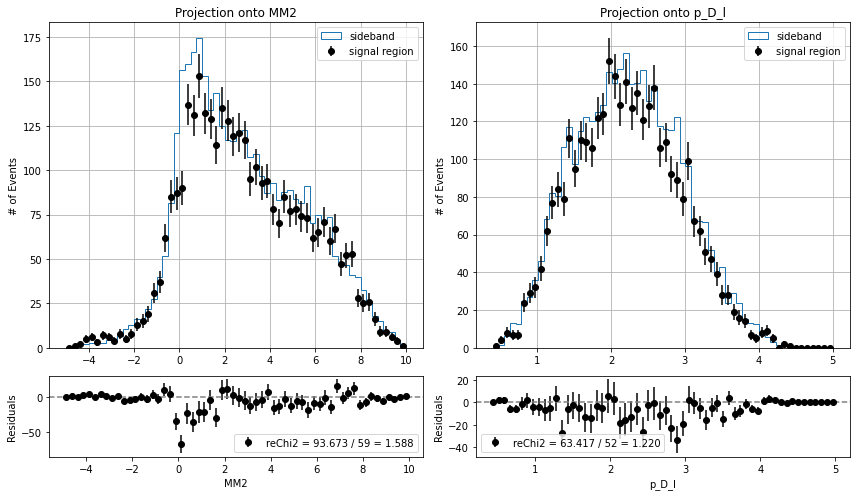

In [9]:
util.compare_2d_hist(temp_o['bkg_fakeD'], temp_sb['bkg_fakeD'], bins_x=MM2_bins, bins_y=p_D_l_bins, 
                       xlabel='MM2', ylabel='p_D_l', data_label='signal region', model_label='sideband')

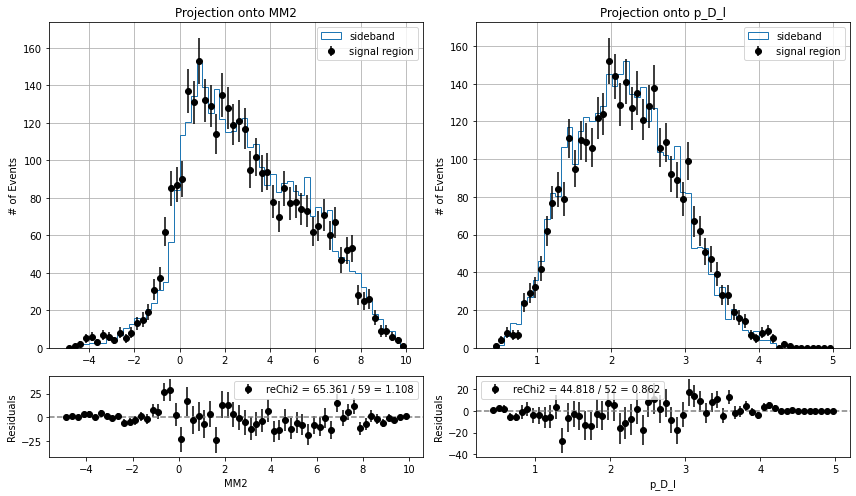

In [31]:
util.compare_2d_hist(temp_o['bkg_fakeD'], temp_sb['bkg_fakeD'], bins_x=MM2_bins, bins_y=p_D_l_bins, 
                       xlabel='MM2', ylabel='p_D_l', data_label='signal region', model_label='sideband')

In [34]:
util.inspect_temp_asimov_channels([(temp_o, data_o)], [(temp_sb,data_sb)])

Channel 0:
  Sample: bkg_fakeD, Data: [[0.0+/-0 0.0+/-0 0.0+/-0 ... 0.0+/-0 1.0+/-1.0 0.0+/-0]
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 1.0+/-1.0 3.0+/-1.7320508075688772 0.0+/-0]
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 3.0+/-1.7320508075688772 0.0+/-0 1.0+/-1.0]
 ...
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 0.0+/-0 0.0+/-0 0.0+/-0]
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 0.0+/-0 0.0+/-0 0.0+/-0]
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 0.0+/-0 0.0+/-0 0.0+/-0]]
    bkg_fakeD templates are different in the 2 inputs
    Sample: bkg_fakeD, Data (from t2): [[0.0+/-0 0.0+/-0 0.0+/-0 ... 0.5541941785448109+/-0.5541941785448109
  0.0+/-0 0.0+/-0]
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 0.0+/-0 0.0+/-0 0.0+/-0]
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 1.920576455970033+/-0.964087494414729
  0.9109215182834814+/-0.6441187827069954 0.0+/-0]
 ...
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 0.0+/-0 0.0+/-0 0.0+/-0]
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 0.0+/-0 0.0+/-0 0.0+/-0]
 [0.0+/-0 0.0+/-0 0.0+/-0 ... 0.0+/-0 0.0+/-0 0.0+/-0]]
  Sample: bkg_TDFl, Data: [[0.0+/-0 0.0+/-0 0.0+/-0 ... 0.0

In [47]:
sig_ch = util.extract_temp_asimov_channels(spec_e,mc_uncer=True)
sb_ch = util.extract_temp_asimov_channels(spec_e_sb,mc_uncer=True)
util.inspect_temp_asimov_channels(sig_ch,sb_ch)

Channel 0:
  Sample: bkg_fakeD, Data: [5.0+/-2.23606797749979 10.0+/-3.1622776601683795 0.0+/-0 ...
 5.0+/-2.23606797749979 0.0+/-0 2.0+/-1.4142135623730951]
    bkg_fakeD templates are different in the 2 inputs
    np.array_equal(nominal1, nominal2)=False, np.array_equal(std1, std2)=False
    Sample: bkg_fakeD, Data (from t2): [7.5737+/-2.752035610234722 10.5833+/-3.253198426164626 0.0+/-0 ...
 4.5546+/-2.134150885012585 0.0+/-0 2.2168+/-1.48889220563478]
  Sample: bkg_TDFl, Data: [1.0+/-1.0 0.0+/-0 0.0+/-0 ... 0.0+/-0 0.0+/-0 1.0+/-1.0]
    bkg_TDFl templates are equal in the 2 inputs
  Sample: bkg_continuum, Data: [7.0+/-2.6457513110645907 3.0+/-1.7320508075688772 1.0+/-1.0 ... 1.0+/-1.0
 1.0+/-1.0 0.0+/-0]
    bkg_continuum templates are equal in the 2 inputs
  Sample: bkg_combinatorial, Data: [9.0+/-3.0 1.0+/-1.0 0.0+/-0 ... 7.0+/-2.6457513110645907 0.0+/-0
 2.0+/-1.4142135623730951]
    bkg_combinatorial templates are equal in the 2 inputs
  Sample: bkg_singleBbkg, Data: [0.0+/-0

In [48]:
temp_o, data_o = util.create_2d_template_from_1d(*sig_ch[0],
                            indices_threshold=indices_threshold_e, bins=[MM2_bins, p_D_l_bins])
temp_sb, data_sb = util.create_2d_template_from_1d(*sb_ch[0],
                            indices_threshold=indices_threshold_e, bins=[MM2_bins, p_D_l_bins])

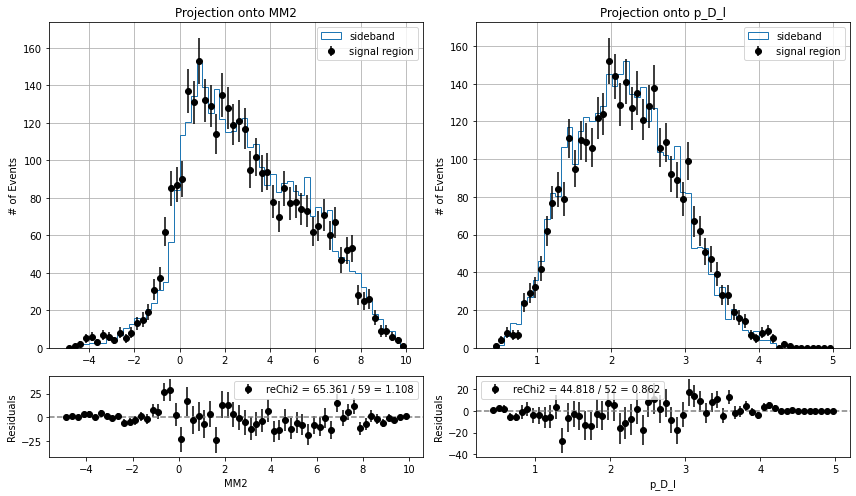

In [26]:
util.compare_2d_hist(temp_o['bkg_fakeD'], temp_sb['bkg_fakeD'], bins_x=MM2_bins, bins_y=p_D_l_bins, 
                       xlabel='MM2', ylabel='p_D_l', data_label='signal region', model_label='sideband')

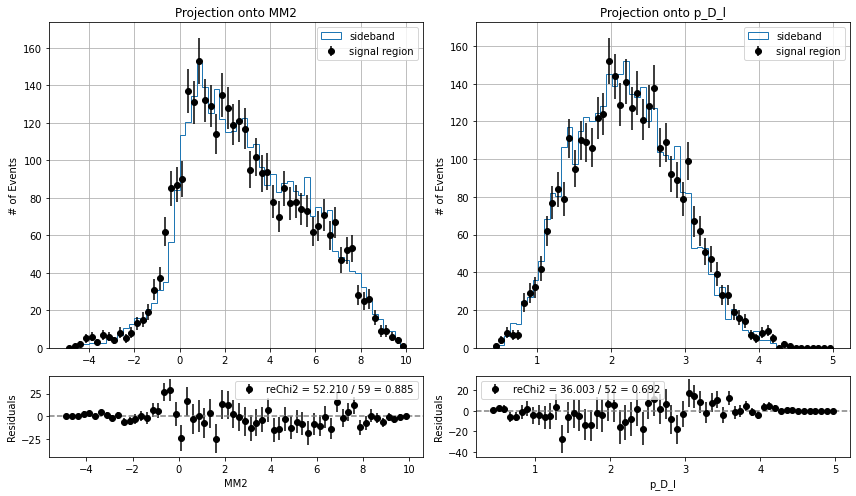

In [49]:
util.compare_2d_hist(temp_o['bkg_fakeD'], temp_sb['bkg_fakeD'], bins_x=MM2_bins, bins_y=p_D_l_bins, 
                       xlabel='MM2', ylabel='p_D_l', data_label='signal region', model_label='sideband')

# 3. Create a pyhf workspace

In [3]:
spec_e = cabinetry.workspace.load('../Toys_pipeline/2d_ws_SR_e_60_60.json')
spec_e_sb = cabinetry.workspace.load('../Toys_pipeline/2d_ws_SR_e_60_60_SBFakeD.json')

In [8]:
workspace_path = '2d_ws_SR_1ch.json'
spec = cabinetry.workspace.load(workspace_path)
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "electron",
            "samples": [
                {
                    "data": [
                        2.0,
                        1.0,
                        5.0,
                        4.0,
                        2.0,
                        1.0,
                        4.0,
                        2.0,
                        10.0,
                        16.0,
                        15.0,
                        20.0,
                        20.0,
                        9.0,
                        4.0,
                        0.0,
                        4.0,
                        5.0,
                        5.0,
                        12.0,
                        17.0,
                        30.0,
                        38.0,
                        40.0,
                        45.0,
                        27.0,
                        13.0,
                        8.0,
                        0.0,
           

In [45]:
# update templates and data in the workspace
# signal region
spec_e = util.update_workspace(workspace=spec,
                             temp_asimov_channels=[temp_asimov_e],
                             mc_uncer=False)

print(json.dumps(spec_e, sort_keys=True, indent=4))

cabinetry.workspace.save(spec_e, '../Toys_pipeline/2d_ws_SR_e_60_60_noMCUncer.json')

{
    "channels": [
        {
            "name": "electron",
            "samples": [
                {
                    "data": [
                        5.0,
                        10.0,
                        0.0,
                        10.0,
                        2.0,
                        2.0,
                        11.0,
                        9.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        4.0,
                        9.0,
                        0.0,
                        1.0,
                        6.0,
                        6.0,
                        8.0,
                        0.0,
                        1.0,
                        2.0,
                        0.0,
                        5.0,
                        2.0,
                        1.0,
                        0.0,
                        1.0,
                        1.0,
                     

DEBUG - cabinetry.workspace - saving workspace to ../Toys_pipeline/2d_ws_SR_e_60_60_noMCUncer.json


In [12]:
!pyhf inspect giordon_spec.json

                     Summary       
               ------------------  
                  channels  1
                   samples  12
                parameters  13
                 modifiers  13

                  channels  nbins
                ----------  -----
                  electron  1111 

                   samples
                ----------
                $D\ell\nu$
            $D\ell\nu$_gap
                $D\tau\nu$
           $D^\ast\ell\nu$
           $D^\ast\tau\nu$
     $D^{\ast\ast}\ell\nu$
     $D^{\ast\ast}\tau\nu$
                  bkg_TDFl
         bkg_combinatorial
             bkg_continuum
                 bkg_fakeD
            bkg_singleBbkg

                parameters  constraint              modifiers
                ----------  ----------              ----------
       $D\ell\nu$_gap_norm  unconstrained           normfactor
           $D\ell\nu$_norm  unconstrained           normfactor
           $D\tau\nu$_norm  unconstrained           normfactor
      $D

In [44]:
# update templates and data in the workspace
# signal region with fakeD from sidebands
spec_e_sb = util.update_workspace(workspace=spec,
                             temp_asimov_channels=[temp_with_sb],
                             mc_uncer=False)

print(json.dumps(spec_e_sb, sort_keys=True, indent=4))

cabinetry.workspace.save(spec_e_sb, '../Toys_pipeline/2d_ws_SR_e_60_60_SBFakeD_noMCUncer.json')

{
    "channels": [
        {
            "name": "electron",
            "samples": [
                {
                    "data": [
                        7.5737,
                        10.5833,
                        0.0,
                        11.4922,
                        1.0097,
                        4.5199,
                        9.4332,
                        7.9785,
                        0.0,
                        0.9942,
                        0.5438,
                        1.4496,
                        4.9062,
                        11.5235,
                        2.0193,
                        0.4141,
                        6.5278,
                        2.2146,
                        7.9717,
                        0.0,
                        0.4555,
                        0.0,
                        0.0,
                        3.7424,
                        8.3734,
                        1.0825,
                        0.0,
                

DEBUG - cabinetry.workspace - saving workspace to ../Toys_pipeline/2d_ws_SR_e_60_60_SBFakeD.json


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

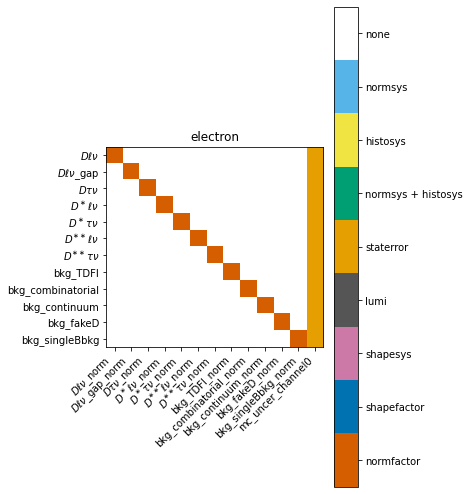

In [11]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec_e).model())

In [4]:
model_sr, data_sr = cabinetry.model_utils.model_and_data(spec_e)
model_sbFakeD, data_sbFakeD = cabinetry.model_utils.model_and_data(spec_e_sb)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

# 4. Asimov fit

In [9]:
model_sbFakeD.config.par_order

['$D\\ell\\nu$_norm',
 '$D\\ell\\nu$_gap_norm',
 '$D\\tau\\nu$_norm',
 '$D^\\ast\\ell\\nu$_norm',
 '$D^\\ast\\tau\\nu$_norm',
 '$D^{\\ast\\ast}\\ell\\nu$_norm',
 '$D^{\\ast\\ast}\\tau\\nu$_norm',
 'bkg_TDFl_norm',
 'bkg_combinatorial_norm',
 'bkg_continuum_norm',
 'bkg_fakeD_norm',
 'bkg_singleBbkg_norm',
 'staterror_0_channel']

In [15]:
%%time
## 200/fb with fakeD from sidebands, binning=60,60
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model_sr, data=data_sr,
                                fix_pars=[False]*7+[True]*5)#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4901                       │              Nfcn = 63               │
│ EDM = 6.24e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   

W VariableMetricBuilder No improvement in line search
CPU times: user 1.08 s, sys: 105 ms, total: 1.18 s
Wall time: 5.46 s


In [16]:
%%time
## 200/fb with fakeD from sidebands, binning=60,60
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model_sbFakeD, data=data_sbFakeD,
                                fix_pars=[False]*7+[True]*5)#, minos=model.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4919                       │              Nfcn = 63               │
│ EDM = 5.65e-11 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

W VariableMetricBuilder No improvement in line search
CPU times: user 287 ms, sys: 3.83 ms, total: 291 ms
Wall time: 269 ms


In [51]:
%%time
## 200/fb with fakeD from sidebands, binning=60,60
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model_sbFakeD, data=data_sr,
                                fix_pars=[False]*7+[True]*5)#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5144                       │         Nfcn = 89, Ngrad = 6         │
│ EDM = 0.000124 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   

CPU times: user 1.31 s, sys: 84.7 ms, total: 1.39 s
Wall time: 5.45 s


In [6]:
%%time
## 200/fb with fakeD from sidebands, binning=60,60
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model_sbFakeD, data=data_sr,
                                fix_pars=[False]*7+[True]*5)#, minos=model.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4119                       │       Nfcn = 619930, Ngrad = 9       │
│ EDM = 0.000247 (Goal: 0.0002)    │           time = 522.9 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - mc_uncer_channel0[88]      =  1.0443 +/- 0.2906
INFO - cabinetry.fit - mc_uncer_channel0[89]      =  0.8437 +/- 0.2812
INFO - cabinetry.fit - mc_uncer_channel0[90]      =  1.0713 +/- 0.1842
INFO - cabinetry.fit - mc_uncer_channel0[91]      =  0.9911 +/- 0.0444
INFO - cabinetry.fit - mc_uncer_channel0[92]      =  0.9933 +/- 0.0532
INFO - cabinetry.fit - mc_uncer_channel0[93]      =  0.8409 +/- 0.1735
INFO - cabinetry.fit - mc_uncer_channel0[94]      =  0.8994 +/- 0.3081
INFO - cabinetry.fit - mc_uncer_channel0[95]      =  1.0156 +/- 0.1398
INFO - cabinetry.fit - mc_uncer_channel0[96]      =  0.9835 +/- 0.0977
INFO - cabinetry.fit - mc_uncer_channel0[97]      =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[98]      =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[99]      =  1.0015 +/- 0.0768
INFO - cabinetry.fit - mc_uncer_channel0[100]     =  1.0000 +/- 0.4977
INFO - cabinetry.fit - mc_uncer_channel0[101]     =  1.0998 +/- 0.3092
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[204]     =  0.6728 +/- 0.3909
INFO - cabinetry.fit - mc_uncer_channel0[205]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[206]     =  0.9051 +/- 0.2733
INFO - cabinetry.fit - mc_uncer_channel0[207]     =  0.7609 +/- 0.2358
INFO - cabinetry.fit - mc_uncer_channel0[208]     =  1.0000 +/- 0.4977
INFO - cabinetry.fit - mc_uncer_channel0[209]     =  0.8187 +/- 0.2157
INFO - cabinetry.fit - mc_uncer_channel0[210]     =  1.0334 +/- 0.0940
INFO - cabinetry.fit - mc_uncer_channel0[211]     =  0.9744 +/- 0.2416
INFO - cabinetry.fit - mc_uncer_channel0[212]     =  0.7309 +/- 0.4625
INFO - cabinetry.fit - mc_uncer_channel0[213]     =  0.9713 +/- 0.0853
INFO - cabinetry.fit - mc_uncer_channel0[214]     =  0.9891 +/- 0.0450
INFO - cabinetry.fit - mc_uncer_channel0[215]     =  1.0077 +/- 0.0621
INFO - cabinetry.fit - mc_uncer_channel0[216]     =  1.0217 +/- 0.0943
INFO - cabinetry.fit - mc_uncer_channel0[217]     =  0.9985 +/- 0.3878
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[320]     =  1.0657 +/- 0.1369
INFO - cabinetry.fit - mc_uncer_channel0[321]     =  0.9826 +/- 0.0844
INFO - cabinetry.fit - mc_uncer_channel0[322]     =  0.9157 +/- 0.0966
INFO - cabinetry.fit - mc_uncer_channel0[323]     =  1.0526 +/- 0.1578
INFO - cabinetry.fit - mc_uncer_channel0[324]     =  1.0052 +/- 0.0496
INFO - cabinetry.fit - mc_uncer_channel0[325]     =  0.9728 +/- 0.1012
INFO - cabinetry.fit - mc_uncer_channel0[326]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[327]     =  0.9935 +/- 0.0827
INFO - cabinetry.fit - mc_uncer_channel0[328]     =  0.9640 +/- 0.0733
INFO - cabinetry.fit - mc_uncer_channel0[329]     =  1.0000 +/- 0.3156
INFO - cabinetry.fit - mc_uncer_channel0[330]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[331]     =  0.8515 +/- 0.1988
INFO - cabinetry.fit - mc_uncer_channel0[332]     =  0.8908 +/- 0.4307
INFO - cabinetry.fit - mc_uncer_channel0[333]     =  0.9972 +/- 0.2352
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[436]     =  0.9326 +/- 0.3134
INFO - cabinetry.fit - mc_uncer_channel0[437]     =  0.9996 +/- 0.0428
INFO - cabinetry.fit - mc_uncer_channel0[438]     =  1.2803 +/- 0.3897
INFO - cabinetry.fit - mc_uncer_channel0[439]     =  0.9975 +/- 0.0703
INFO - cabinetry.fit - mc_uncer_channel0[440]     =  0.9256 +/- 0.2050
INFO - cabinetry.fit - mc_uncer_channel0[441]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[442]     =  0.9738 +/- 0.1106
INFO - cabinetry.fit - mc_uncer_channel0[443]     =  1.0000 +/- 0.4977
INFO - cabinetry.fit - mc_uncer_channel0[444]     =  1.0188 +/- 0.0948
INFO - cabinetry.fit - mc_uncer_channel0[445]     =  1.4143 +/- 0.7023
INFO - cabinetry.fit - mc_uncer_channel0[446]     =  0.9593 +/- 0.2739
INFO - cabinetry.fit - mc_uncer_channel0[447]     =  0.8908 +/- 0.4307
INFO - cabinetry.fit - mc_uncer_channel0[448]     =  1.0000 +/- 0.4070
INFO - cabinetry.fit - mc_uncer_channel0[449]     =  0.6640 +/- 0.3629
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[552]     =  0.9901 +/- 0.0867
INFO - cabinetry.fit - mc_uncer_channel0[553]     =  1.0119 +/- 0.0583
INFO - cabinetry.fit - mc_uncer_channel0[554]     =  1.0000 +/- 0.4977
INFO - cabinetry.fit - mc_uncer_channel0[555]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[556]     =  1.0236 +/- 0.0742
INFO - cabinetry.fit - mc_uncer_channel0[557]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[558]     =  1.0997 +/- 0.2286
INFO - cabinetry.fit - mc_uncer_channel0[559]     =  0.7655 +/- 0.4803
INFO - cabinetry.fit - mc_uncer_channel0[560]     =  1.1547 +/- 0.4071
INFO - cabinetry.fit - mc_uncer_channel0[561]     =  0.9563 +/- 0.2042
INFO - cabinetry.fit - mc_uncer_channel0[562]     =  0.9467 +/- 0.3179
INFO - cabinetry.fit - mc_uncer_channel0[563]     =  1.0003 +/- 0.0463
INFO - cabinetry.fit - mc_uncer_channel0[564]     =  0.9981 +/- 0.0554
INFO - cabinetry.fit - mc_uncer_channel0[565]     =  1.0098 +/- 0.1491
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[668]     =  0.9916 +/- 0.0890
INFO - cabinetry.fit - mc_uncer_channel0[669]     =  1.0350 +/- 0.2569
INFO - cabinetry.fit - mc_uncer_channel0[670]     =  0.9818 +/- 0.1724
INFO - cabinetry.fit - mc_uncer_channel0[671]     =  0.8133 +/- 0.3064
INFO - cabinetry.fit - mc_uncer_channel0[672]     =  1.0082 +/- 0.0490
INFO - cabinetry.fit - mc_uncer_channel0[673]     =  1.0406 +/- 0.2580
INFO - cabinetry.fit - mc_uncer_channel0[674]     =  0.9667 +/- 0.0845
INFO - cabinetry.fit - mc_uncer_channel0[675]     =  0.9077 +/- 0.4386
INFO - cabinetry.fit - mc_uncer_channel0[676]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[677]     =  1.0502 +/- 0.0948
INFO - cabinetry.fit - mc_uncer_channel0[678]     =  0.8739 +/- 0.3421
INFO - cabinetry.fit - mc_uncer_channel0[679]     =  1.1031 +/- 0.2852
INFO - cabinetry.fit - mc_uncer_channel0[680]     =  1.0245 +/- 0.1107
INFO - cabinetry.fit - mc_uncer_channel0[681]     =  1.0000 +/- 0.4977
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[784]     =  1.0710 +/- 0.1007
INFO - cabinetry.fit - mc_uncer_channel0[785]     =  0.9279 +/- 0.2622
INFO - cabinetry.fit - mc_uncer_channel0[786]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[787]     =  0.9796 +/- 0.0847
INFO - cabinetry.fit - mc_uncer_channel0[788]     =  0.8908 +/- 0.4307
INFO - cabinetry.fit - mc_uncer_channel0[789]     =  1.0096 +/- 0.0394
INFO - cabinetry.fit - mc_uncer_channel0[790]     =  1.0431 +/- 0.2586
INFO - cabinetry.fit - mc_uncer_channel0[791]     =  1.0111 +/- 0.0744
INFO - cabinetry.fit - mc_uncer_channel0[792]     =  0.8588 +/- 0.2587
INFO - cabinetry.fit - mc_uncer_channel0[793]     =  0.9782 +/- 0.0611
INFO - cabinetry.fit - mc_uncer_channel0[794]     =  1.0000 +/- 0.4977
INFO - cabinetry.fit - mc_uncer_channel0[795]     =  0.9855 +/- 0.1220
INFO - cabinetry.fit - mc_uncer_channel0[796]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[797]     =  1.0000 +/- 0.7006
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[900]     =  0.9823 +/- 0.0715
INFO - cabinetry.fit - mc_uncer_channel0[901]     =  0.9946 +/- 0.0725
INFO - cabinetry.fit - mc_uncer_channel0[902]     =  1.0844 +/- 0.2835
INFO - cabinetry.fit - mc_uncer_channel0[903]     =  0.9490 +/- 0.3297
INFO - cabinetry.fit - mc_uncer_channel0[904]     =  0.9326 +/- 0.2299
INFO - cabinetry.fit - mc_uncer_channel0[905]     =  1.0587 +/- 0.3670
INFO - cabinetry.fit - mc_uncer_channel0[906]     =  1.0004 +/- 0.0528
INFO - cabinetry.fit - mc_uncer_channel0[907]     =  0.9964 +/- 0.0575
INFO - cabinetry.fit - mc_uncer_channel0[908]     =  1.0314 +/- 0.1244
INFO - cabinetry.fit - mc_uncer_channel0[909]     =  0.9077 +/- 0.4386
INFO - cabinetry.fit - mc_uncer_channel0[910]     =  0.9401 +/- 0.1692
INFO - cabinetry.fit - mc_uncer_channel0[911]     =  1.0021 +/- 0.0748
INFO - cabinetry.fit - mc_uncer_channel0[912]     =  1.0394 +/- 0.0721
INFO - cabinetry.fit - mc_uncer_channel0[913]     =  1.0108 +/- 0.0468
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[1016]    =  0.9977 +/- 0.3524
INFO - cabinetry.fit - mc_uncer_channel0[1017]    =  0.9876 +/- 0.3369
INFO - cabinetry.fit - mc_uncer_channel0[1018]    =  1.0691 +/- 0.2669
INFO - cabinetry.fit - mc_uncer_channel0[1019]    =  1.0587 +/- 0.3670
INFO - cabinetry.fit - mc_uncer_channel0[1020]    =  1.0006 +/- 0.0488
INFO - cabinetry.fit - mc_uncer_channel0[1021]    =  0.8859 +/- 0.1696
INFO - cabinetry.fit - mc_uncer_channel0[1022]    =  1.0054 +/- 0.0534
INFO - cabinetry.fit - mc_uncer_channel0[1023]    =  0.9998 +/- 0.0450
INFO - cabinetry.fit - mc_uncer_channel0[1024]    =  1.0205 +/- 0.0864
INFO - cabinetry.fit - mc_uncer_channel0[1025]    =  1.0936 +/- 0.1985
INFO - cabinetry.fit - mc_uncer_channel0[1026]    =  1.0036 +/- 0.0694
INFO - cabinetry.fit - mc_uncer_channel0[1027]    =  1.0000 +/- 0.4977
INFO - cabinetry.fit - mc_uncer_channel0[1028]    =  1.0135 +/- 0.0805
INFO - cabinetry.fit - mc_uncer_channel0[1029]    =  1.0000 +/- 0.7006
INFO -

CPU times: user 15min 7s, sys: 21.5 s, total: 15min 28s
Wall time: 10min 47s


In [52]:
%%time
## 200/fb with fakeD from sidebands, binning=60,60
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model_sr, data=data_sbFakeD,
                                fix_pars=[False]*7+[True]*5)#, minos=model.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5164                       │         Nfcn = 93, Ngrad = 7         │
│ EDM = 1.54e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

CPU times: user 320 ms, sys: 4.81 ms, total: 325 ms
Wall time: 292 ms


In [7]:
%%time
## 200/fb with fakeD from sidebands, binning=60,60
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model_sr, data=data_sbFakeD,
                                fix_pars=[False]*7+[True]*5)#, minos=model.config.parameters[:7])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4214                       │      Nfcn = 619939, Ngrad = 11       │
│ EDM = 0.000273 (Goal: 0.0002)    │           time = 485.3 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - mc_uncer_channel0[88]      =  0.9545 +/- 0.2883
INFO - cabinetry.fit - mc_uncer_channel0[89]      =  1.2093 +/- 0.3551
INFO - cabinetry.fit - mc_uncer_channel0[90]      =  0.9298 +/- 0.1767
INFO - cabinetry.fit - mc_uncer_channel0[91]      =  1.0078 +/- 0.0449
INFO - cabinetry.fit - mc_uncer_channel0[92]      =  1.0063 +/- 0.0537
INFO - cabinetry.fit - mc_uncer_channel0[93]      =  1.2215 +/- 0.2234
INFO - cabinetry.fit - mc_uncer_channel0[94]      =  1.1162 +/- 0.3518
INFO - cabinetry.fit - mc_uncer_channel0[95]      =  0.9800 +/- 0.1384
INFO - cabinetry.fit - mc_uncer_channel0[96]      =  1.0156 +/- 0.1011
INFO - cabinetry.fit - mc_uncer_channel0[97]      =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[98]      =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[99]      =  0.9933 +/- 0.0782
INFO - cabinetry.fit - mc_uncer_channel0[100]     =  1.0000 +/- 0.4977
INFO - cabinetry.fit - mc_uncer_channel0[101]     =  0.9047 +/- 0.2882
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[204]     =  1.6873 +/- 0.7149
INFO - cabinetry.fit - mc_uncer_channel0[205]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[206]     =  1.1104 +/- 0.3170
INFO - cabinetry.fit - mc_uncer_channel0[207]     =  1.3796 +/- 0.3504
INFO - cabinetry.fit - mc_uncer_channel0[208]     =  1.0000 +/- 0.4977
INFO - cabinetry.fit - mc_uncer_channel0[209]     =  1.2645 +/- 0.2883
INFO - cabinetry.fit - mc_uncer_channel0[210]     =  0.9576 +/- 0.0937
INFO - cabinetry.fit - mc_uncer_channel0[211]     =  1.0264 +/- 0.2497
INFO - cabinetry.fit - mc_uncer_channel0[212]     =  1.4521 +/- 0.7024
INFO - cabinetry.fit - mc_uncer_channel0[213]     =  1.0274 +/- 0.0900
INFO - cabinetry.fit - mc_uncer_channel0[214]     =  1.0111 +/- 0.0455
INFO - cabinetry.fit - mc_uncer_channel0[215]     =  0.9920 +/- 0.0616
INFO - cabinetry.fit - mc_uncer_channel0[216]     =  0.9787 +/- 0.0924
INFO - cabinetry.fit - mc_uncer_channel0[217]     =  1.0016 +/- 0.4070
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[320]     =  0.9325 +/- 0.1320
INFO - cabinetry.fit - mc_uncer_channel0[321]     =  1.0177 +/- 0.0862
INFO - cabinetry.fit - mc_uncer_channel0[322]     =  1.0909 +/- 0.1090
INFO - cabinetry.fit - mc_uncer_channel0[323]     =  0.9428 +/- 0.1510
INFO - cabinetry.fit - mc_uncer_channel0[324]     =  0.9935 +/- 0.0495
INFO - cabinetry.fit - mc_uncer_channel0[325]     =  1.0259 +/- 0.1045
INFO - cabinetry.fit - mc_uncer_channel0[326]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[327]     =  0.9983 +/- 0.0850
INFO - cabinetry.fit - mc_uncer_channel0[328]     =  1.0351 +/- 0.0774
INFO - cabinetry.fit - mc_uncer_channel0[329]     =  1.0000 +/- 0.3156
INFO - cabinetry.fit - mc_uncer_channel0[330]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[331]     =  1.2002 +/- 0.2506
INFO - cabinetry.fit - mc_uncer_channel0[332]     =  1.1301 +/- 0.4979
INFO - cabinetry.fit - mc_uncer_channel0[333]     =  1.0025 +/- 0.2358
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[436]     =  1.0796 +/- 0.3528
INFO - cabinetry.fit - mc_uncer_channel0[437]     =  1.0006 +/- 0.0429
INFO - cabinetry.fit - mc_uncer_channel0[438]     =  0.7656 +/- 0.3161
INFO - cabinetry.fit - mc_uncer_channel0[439]     =  1.0036 +/- 0.0716
INFO - cabinetry.fit - mc_uncer_channel0[440]     =  1.0757 +/- 0.2245
INFO - cabinetry.fit - mc_uncer_channel0[441]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[442]     =  1.0233 +/- 0.1170
INFO - cabinetry.fit - mc_uncer_channel0[443]     =  1.0000 +/- 0.4977
INFO - cabinetry.fit - mc_uncer_channel0[444]     =  0.9735 +/- 0.0941
INFO - cabinetry.fit - mc_uncer_channel0[445]     =  0.7070 +/- 0.4968
INFO - cabinetry.fit - mc_uncer_channel0[446]     =  1.0429 +/- 0.2881
INFO - cabinetry.fit - mc_uncer_channel0[447]     =  1.1301 +/- 0.4979
INFO - cabinetry.fit - mc_uncer_channel0[448]     =  1.0000 +/- 0.4070
INFO - cabinetry.fit - mc_uncer_channel0[449]     =  1.8103 +/- 0.7031
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[552]     =  1.0074 +/- 0.0884
INFO - cabinetry.fit - mc_uncer_channel0[553]     =  0.9881 +/- 0.0579
INFO - cabinetry.fit - mc_uncer_channel0[554]     =  1.0000 +/- 0.4977
INFO - cabinetry.fit - mc_uncer_channel0[555]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[556]     =  0.9722 +/- 0.0731
INFO - cabinetry.fit - mc_uncer_channel0[557]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[558]     =  0.8987 +/- 0.2129
INFO - cabinetry.fit - mc_uncer_channel0[559]     =  1.3824 +/- 0.7022
INFO - cabinetry.fit - mc_uncer_channel0[560]     =  0.8660 +/- 0.3526
INFO - cabinetry.fit - mc_uncer_channel0[561]     =  1.0507 +/- 0.2239
INFO - cabinetry.fit - mc_uncer_channel0[562]     =  1.0611 +/- 0.3521
INFO - cabinetry.fit - mc_uncer_channel0[563]     =  0.9993 +/- 0.0463
INFO - cabinetry.fit - mc_uncer_channel0[564]     =  1.0017 +/- 0.0555
INFO - cabinetry.fit - mc_uncer_channel0[565]     =  0.9902 +/- 0.1478
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[668]     =  1.0086 +/- 0.0901
INFO - cabinetry.fit - mc_uncer_channel0[669]     =  0.9657 +/- 0.2500
INFO - cabinetry.fit - mc_uncer_channel0[670]     =  1.0145 +/- 0.1825
INFO - cabinetry.fit - mc_uncer_channel0[671]     =  1.2678 +/- 0.4072
INFO - cabinetry.fit - mc_uncer_channel0[672]     =  0.9915 +/- 0.0488
INFO - cabinetry.fit - mc_uncer_channel0[673]     =  0.9589 +/- 0.2491
INFO - cabinetry.fit - mc_uncer_channel0[674]     =  1.0316 +/- 0.0891
INFO - cabinetry.fit - mc_uncer_channel0[675]     =  1.1080 +/- 0.4979
INFO - cabinetry.fit - mc_uncer_channel0[676]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[677]     =  0.9458 +/- 0.0912
INFO - cabinetry.fit - mc_uncer_channel0[678]     =  1.1561 +/- 0.4071
INFO - cabinetry.fit - mc_uncer_channel0[679]     =  0.9013 +/- 0.2672
INFO - cabinetry.fit - mc_uncer_channel0[680]     =  0.9762 +/- 0.1082
INFO - cabinetry.fit - mc_uncer_channel0[681]     =  1.0000 +/- 0.4977
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[784]     =  0.9283 +/- 0.0953
INFO - cabinetry.fit - mc_uncer_channel0[785]     =  1.0809 +/- 0.2883
INFO - cabinetry.fit - mc_uncer_channel0[786]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[787]     =  1.0183 +/- 0.0888
INFO - cabinetry.fit - mc_uncer_channel0[788]     =  1.1301 +/- 0.4979
INFO - cabinetry.fit - mc_uncer_channel0[789]     =  0.9904 +/- 0.0391
INFO - cabinetry.fit - mc_uncer_channel0[790]     =  0.9580 +/- 0.2494
INFO - cabinetry.fit - mc_uncer_channel0[791]     =  0.9892 +/- 0.0736
INFO - cabinetry.fit - mc_uncer_channel0[792]     =  1.1794 +/- 0.3153
INFO - cabinetry.fit - mc_uncer_channel0[793]     =  1.0229 +/- 0.0633
INFO - cabinetry.fit - mc_uncer_channel0[794]     =  1.0000 +/- 0.4977
INFO - cabinetry.fit - mc_uncer_channel0[795]     =  1.0069 +/- 0.1267
INFO - cabinetry.fit - mc_uncer_channel0[796]     =  1.0000 +/- 0.7006
INFO - cabinetry.fit - mc_uncer_channel0[797]     =  1.0000 +/- 0.7006
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[900]     =  1.0119 +/- 0.0740
INFO - cabinetry.fit - mc_uncer_channel0[901]     =  1.0054 +/- 0.0742
INFO - cabinetry.fit - mc_uncer_channel0[902]     =  0.9189 +/- 0.2669
INFO - cabinetry.fit - mc_uncer_channel0[903]     =  1.0554 +/- 0.3528
INFO - cabinetry.fit - mc_uncer_channel0[904]     =  1.0847 +/- 0.2669
INFO - cabinetry.fit - mc_uncer_channel0[905]     =  0.9426 +/- 0.3527
INFO - cabinetry.fit - mc_uncer_channel0[906]     =  0.9998 +/- 0.0529
INFO - cabinetry.fit - mc_uncer_channel0[907]     =  1.0035 +/- 0.0578
INFO - cabinetry.fit - mc_uncer_channel0[908]     =  0.9646 +/- 0.1248
INFO - cabinetry.fit - mc_uncer_channel0[909]     =  1.1080 +/- 0.4979
INFO - cabinetry.fit - mc_uncer_channel0[910]     =  1.0656 +/- 0.1827
INFO - cabinetry.fit - mc_uncer_channel0[911]     =  0.9991 +/- 0.0756
INFO - cabinetry.fit - mc_uncer_channel0[912]     =  0.9608 +/- 0.0695
INFO - cabinetry.fit - mc_uncer_channel0[913]     =  0.9890 +/- 0.0464
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[1016]    =  1.0023 +/- 0.3532
INFO - cabinetry.fit - mc_uncer_channel0[1017]    =  1.0135 +/- 0.3527
INFO - cabinetry.fit - mc_uncer_channel0[1018]    =  0.9354 +/- 0.2497
INFO - cabinetry.fit - mc_uncer_channel0[1019]    =  0.9426 +/- 0.3527
INFO - cabinetry.fit - mc_uncer_channel0[1020]    =  0.9988 +/- 0.0490
INFO - cabinetry.fit - mc_uncer_channel0[1021]    =  1.1461 +/- 0.2040
INFO - cabinetry.fit - mc_uncer_channel0[1022]    =  0.9943 +/- 0.0533
INFO - cabinetry.fit - mc_uncer_channel0[1023]    =  0.9999 +/- 0.0451
INFO - cabinetry.fit - mc_uncer_channel0[1024]    =  0.9736 +/- 0.0853
INFO - cabinetry.fit - mc_uncer_channel0[1025]    =  0.9066 +/- 0.1830
INFO - cabinetry.fit - mc_uncer_channel0[1026]    =  0.9944 +/- 0.0699
INFO - cabinetry.fit - mc_uncer_channel0[1027]    =  1.0000 +/- 0.4977
INFO - cabinetry.fit - mc_uncer_channel0[1028]    =  0.9804 +/- 0.0806
INFO - cabinetry.fit - mc_uncer_channel0[1029]    =  1.0000 +/- 0.7006
INFO -

CPU times: user 13min 57s, sys: 19.1 s, total: 14min 16s
Wall time: 10min 9s


In [6]:
%%time
## Asimov test with 200/fb, binning=50,25
pyhf.set_backend("jax")
fit_results = cabinetry.fit.fit(model=model, data=data,
                                fix_pars=[False,False,False,False,False,False])#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit


W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1440                       │             Nfcn = 82603             │
│ EDM = 7.23e-10 (Goal: 0.0002)    │           time = 33.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 1440.329018 at

INFO - cabinetry.fit - staterror_0_channel[89]    =  1.0000 +/- 0.1122
INFO - cabinetry.fit - staterror_0_channel[90]    =  1.0000 +/- 0.0922
INFO - cabinetry.fit - staterror_0_channel[91]    =  1.0000 +/- 0.0785
INFO - cabinetry.fit - staterror_0_channel[92]    =  1.0000 +/- 0.0676
INFO - cabinetry.fit - staterror_0_channel[93]    =  1.0000 +/- 0.0591
INFO - cabinetry.fit - staterror_0_channel[94]    =  1.0000 +/- 0.0536
INFO - cabinetry.fit - staterror_0_channel[95]    =  1.0000 +/- 0.0470
INFO - cabinetry.fit - staterror_0_channel[96]    =  1.0000 +/- 0.0464
INFO - cabinetry.fit - staterror_0_channel[97]    =  1.0000 +/- 0.0387
INFO - cabinetry.fit - staterror_0_channel[98]    =  1.0000 +/- 0.0412
INFO - cabinetry.fit - staterror_0_channel[99]    =  1.0000 +/- 0.0435
INFO - cabinetry.fit - staterror_0_channel[100]   =  1.0000 +/- 0.0531
INFO - cabinetry.fit - staterror_0_channel[101]   =  1.0000 +/- 0.0699
INFO - cabinetry.fit - staterror_0_channel[102]   =  1.0000 +/- 0.1555
INFO -

INFO - cabinetry.fit - staterror_0_channel[205]   =  1.0000 +/- 0.0625
INFO - cabinetry.fit - staterror_0_channel[206]   =  1.0000 +/- 0.0492
INFO - cabinetry.fit - staterror_0_channel[207]   =  1.0000 +/- 0.0427
INFO - cabinetry.fit - staterror_0_channel[208]   =  1.0000 +/- 0.0374
INFO - cabinetry.fit - staterror_0_channel[209]   =  1.0000 +/- 0.0323
INFO - cabinetry.fit - staterror_0_channel[210]   =  1.0000 +/- 0.0300
INFO - cabinetry.fit - staterror_0_channel[211]   =  1.0000 +/- 0.0278
INFO - cabinetry.fit - staterror_0_channel[212]   =  1.0000 +/- 0.0291
INFO - cabinetry.fit - staterror_0_channel[213]   =  1.0000 +/- 0.0341
INFO - cabinetry.fit - staterror_0_channel[214]   =  1.0000 +/- 0.0357
INFO - cabinetry.fit - staterror_0_channel[215]   =  1.0000 +/- 0.0364
INFO - cabinetry.fit - staterror_0_channel[216]   =  1.0000 +/- 0.0398
INFO - cabinetry.fit - staterror_0_channel[217]   =  1.0000 +/- 0.0412
INFO - cabinetry.fit - staterror_0_channel[218]   =  1.0000 +/- 0.0502
INFO -

INFO - cabinetry.fit - staterror_0_channel[321]   =  1.0000 +/- 0.3184
INFO - cabinetry.fit - staterror_0_channel[322]   =  1.0000 +/- 0.4145
INFO - cabinetry.fit - staterror_0_channel[323]   =  1.0000 +/- 0.2677
INFO - cabinetry.fit - staterror_0_channel[324]   =  1.0000 +/- 0.2258
INFO - cabinetry.fit - staterror_0_channel[325]   =  1.0000 +/- 0.2057
INFO - cabinetry.fit - staterror_0_channel[326]   =  1.0000 +/- 0.0833
INFO - cabinetry.fit - staterror_0_channel[327]   =  1.0000 +/- 0.0446
INFO - cabinetry.fit - staterror_0_channel[328]   =  1.0000 +/- 0.0369
INFO - cabinetry.fit - staterror_0_channel[329]   =  1.0000 +/- 0.0327
INFO - cabinetry.fit - staterror_0_channel[330]   =  1.0000 +/- 0.0293
INFO - cabinetry.fit - staterror_0_channel[331]   =  1.0000 +/- 0.0319
INFO - cabinetry.fit - staterror_0_channel[332]   =  1.0000 +/- 0.0548
INFO - cabinetry.fit - staterror_0_channel[333]   =  1.0000 +/- 0.1345
INFO - cabinetry.fit - staterror_0_channel[334]   =  1.0000 +/- 0.7085
INFO -

CPU times: user 1min 1s, sys: 634 ms, total: 1min 1s
Wall time: 1min 17s


In [ ]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


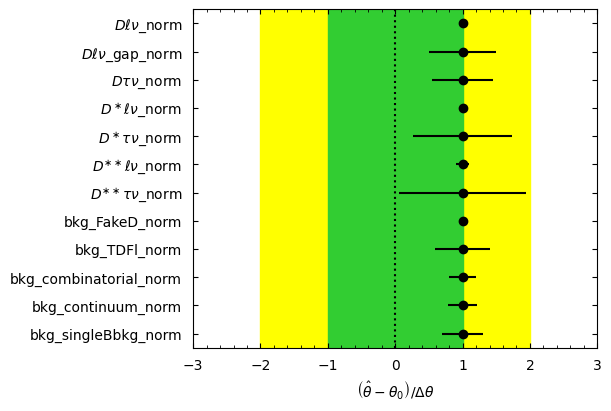

In [22]:
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


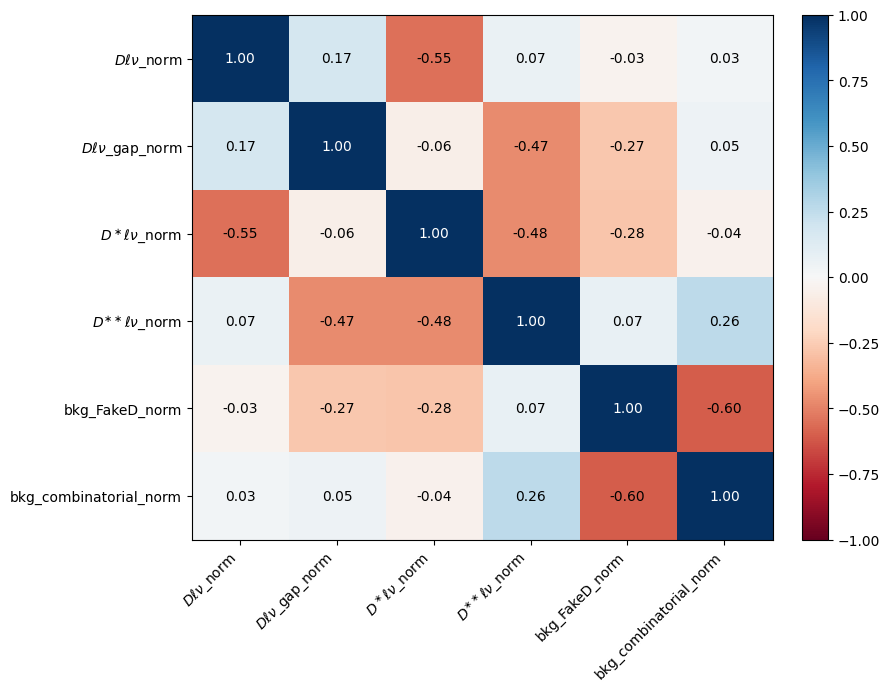

In [28]:
# 3/ab template with weight=0.12 and no staterror
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.35)

INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3955                       │              Nfcn = 73               │
│ EDM = 2.23e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3955.304735 at

W VariableMetricBuilder No improvement in line search


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3960                       │        Nfcn = 101, Ngrad = 9         │
│ EDM = 0.000513 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3960.403538 at

DEBUG - cabinetry.fit - -2 log(L) = 3957.894671 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.565
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3958                       │         Nfcn = 99, Ngrad = 8         │
│ EDM = 1.63e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3956.059152 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.778
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3956                       │        Nfcn = 101, Ngrad = 8         │
│ EDM = 1.25e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3955.321419 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 0.990
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3955                       │         Nfcn = 75, Ngrad = 2         │
│ EDM = 0.000493 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3955.679596 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 1.202
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3956                       │         Nfcn = 95, Ngrad = 8         │
│ EDM = 1.37e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3957.135240 at best-fit point
DEBUG - cabinetry.fit - performing fit with $D\tau\nu$_norm = 1.414
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3957                       │         Nfcn = 98, Ngrad = 9         │
│ EDM = 6.46e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not f

DEBUG - cabinetry.fit - -2 log(L) = 3959.692705 at best-fit point
INFO - cabinetry.visualize.utils - saving figure as figures/scan_$D\tau\nu$_norm.pdf


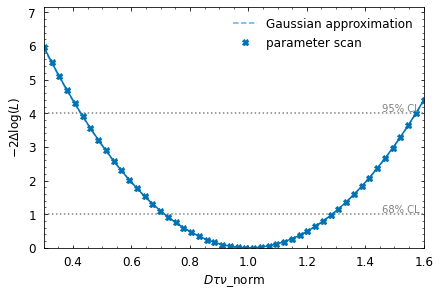

In [80]:
scan_0=cabinetry.fit.scan(model=model, data=data,par_name=r'$D\tau\nu$_norm',par_range=[0.3,1.6],n_steps=50)
cabinetry.visualize.scan(scan_0)

In [ ]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, log_scale=False)
for i in _:
    i['figure'].set_figwidth(12)

# 5. Test Toys workflow

In [3]:
spec_e = cabinetry.workspace.load('../Toys_pipeline/2d_ws_SR_e_60_60.json')
spec_e_sb = cabinetry.workspace.load('../Toys_pipeline/2d_ws_SR_e_60_60_SBFakeD.json')
model_sr, data_sr = cabinetry.model_utils.model_and_data(spec_e)
model_sbFakeD, data_sbFakeD = cabinetry.model_utils.model_and_data(spec_e_sb)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\ell\nu$_gap_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_TDFl_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_combinatorial_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_continuum_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier bkg_fakeD_

In [6]:
0 in model_sr.expected_actualdata([1]*1111)

False

In [7]:
0 in model_sbFakeD.expected_actualdata([1]*1111)

False

In [8]:
samples_toFix = ['bkg_fakeD','bkg_TDFl','bkg_continuum',
                 'bkg_combinatorial','bkg_singleBbkg','bkg_fakeTracks',]

model_test = model_sr
model_temp = model_sbFakeD
        
# Get the list of all sample names from the model
all_sample_names = model_sr.config.samples
# Create a boolean list for fixing parameters
fix_mask = [sample in samples_toFix for sample in all_sample_names]
        
# Retrieve all parameter names in the correct order
all_parameter_names = model_sr.config.par_order
# Create a list of parameter names for samples that are not fixed
minos_parameters = [param for param, fix in zip(all_parameter_names, fix_mask) if not fix]
        
# Generate toys   
toy_pars = model_test.config.suggested_init()
toy_pars[:12] = [1]*12
# generate the toys:
pdf_toy = model_test.make_pdf(pyhf.tensorlib.astensor(toy_pars))

toys = pdf_toy.sample((3,))

In [ ]:
pyhf.set_backend('jax', 'scipy')
init_pars = pyhf.infer.mle.fit(data=toys[0], pdf=model_temp,
                               init_pars=toy_pars,
                               fixed_params=fix_mask,
                              ).tolist()
init_pars[:12]

In [10]:
pyhf.set_backend('jax', 'minuit')
res = cabinetry.fit.fit(
    model_temp,
    data=toys[0],
    init_pars=toy_pars,
    fix_pars = fix_mask,
    # par_bounds=par_bounds,
    goodness_of_fit=True,
#     minos=minos_parameters
)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5170                       │      Nfcn = 620055, Ngrad = 25       │
│ EDM = 0.00106 (Goal: 0.0002)     │           time = 464.7 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.fit - mc_uncer_channel0[88]      =  1.2292 +/- 0.2932
INFO - cabinetry.fit - mc_uncer_channel0[89]      =  0.8777 +/- 0.2722
INFO - cabinetry.fit - mc_uncer_channel0[90]      =  1.0612 +/- 0.1891
INFO - cabinetry.fit - mc_uncer_channel0[91]      =  0.9418 +/- 0.0446
INFO - cabinetry.fit - mc_uncer_channel0[92]      =  1.0535 +/- 0.0538
INFO - cabinetry.fit - mc_uncer_channel0[93]      =  0.5341 +/- 0.1514
INFO - cabinetry.fit - mc_uncer_channel0[94]      =  1.5392 +/- 0.3948
INFO - cabinetry.fit - mc_uncer_channel0[95]      =  0.7512 +/- 0.1295
INFO - cabinetry.fit - mc_uncer_channel0[96]      =  1.0905 +/- 0.1011
INFO - cabinetry.fit - mc_uncer_channel0[97]      =  0.5894 +/- 0.5038
INFO - cabinetry.fit - mc_uncer_channel0[98]      =  0.0000 +/- 0.5173
INFO - cabinetry.fit - mc_uncer_channel0[99]      =  1.1126 +/- 0.0778
INFO - cabinetry.fit - mc_uncer_channel0[100]     =  0.5577 +/- 0.4353
INFO - cabinetry.fit - mc_uncer_channel0[101]     =  0.8812 +/- 0.3267
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[204]     =  0.4460 +/- 0.4789
INFO - cabinetry.fit - mc_uncer_channel0[205]     =  0.0000 +/- 0.4433
INFO - cabinetry.fit - mc_uncer_channel0[206]     =  0.8904 +/- 0.2848
INFO - cabinetry.fit - mc_uncer_channel0[207]     =  0.6059 +/- 0.2012
INFO - cabinetry.fit - mc_uncer_channel0[208]     =  0.7845 +/- 0.3421
INFO - cabinetry.fit - mc_uncer_channel0[209]     =  0.8287 +/- 0.2334
INFO - cabinetry.fit - mc_uncer_channel0[210]     =  0.8119 +/- 0.0840
INFO - cabinetry.fit - mc_uncer_channel0[211]     =  0.6647 +/- 0.2539
INFO - cabinetry.fit - mc_uncer_channel0[212]     =  0.1458 +/- 0.1414
INFO - cabinetry.fit - mc_uncer_channel0[213]     =  0.8580 +/- 0.0823
INFO - cabinetry.fit - mc_uncer_channel0[214]     =  0.9476 +/- 0.0451
INFO - cabinetry.fit - mc_uncer_channel0[215]     =  0.9674 +/- 0.0623
INFO - cabinetry.fit - mc_uncer_channel0[216]     =  0.9784 +/- 0.0910
INFO - cabinetry.fit - mc_uncer_channel0[217]     =  1.1735 +/- 0.3710
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[320]     =  1.1242 +/- 0.1362
INFO - cabinetry.fit - mc_uncer_channel0[321]     =  0.8633 +/- 0.0808
INFO - cabinetry.fit - mc_uncer_channel0[322]     =  0.9786 +/- 0.0975
INFO - cabinetry.fit - mc_uncer_channel0[323]     =  1.1933 +/- 0.1611
INFO - cabinetry.fit - mc_uncer_channel0[324]     =  0.9525 +/- 0.0494
INFO - cabinetry.fit - mc_uncer_channel0[325]     =  0.9868 +/- 0.1024
INFO - cabinetry.fit - mc_uncer_channel0[326]     =  0.7271 +/- 0.5831
INFO - cabinetry.fit - mc_uncer_channel0[327]     =  0.8942 +/- 0.0830
INFO - cabinetry.fit - mc_uncer_channel0[328]     =  1.0430 +/- 0.0755
INFO - cabinetry.fit - mc_uncer_channel0[329]     =  1.3247 +/- 0.3440
INFO - cabinetry.fit - mc_uncer_channel0[330]     =  0.1072 +/- 2.1112
INFO - cabinetry.fit - mc_uncer_channel0[331]     =  1.0615 +/- 0.2121
INFO - cabinetry.fit - mc_uncer_channel0[332]     =  1.3443 +/- 0.5023
INFO - cabinetry.fit - mc_uncer_channel0[333]     =  0.7923 +/- 0.2143
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[436]     =  0.7986 +/- 0.2904
INFO - cabinetry.fit - mc_uncer_channel0[437]     =  1.0186 +/- 0.0429
INFO - cabinetry.fit - mc_uncer_channel0[438]     =  1.2125 +/- 0.3471
INFO - cabinetry.fit - mc_uncer_channel0[439]     =  1.0039 +/- 0.0680
INFO - cabinetry.fit - mc_uncer_channel0[440]     =  1.0363 +/- 0.2115
INFO - cabinetry.fit - mc_uncer_channel0[441]     =  1.3993 +/- 0.5707
INFO - cabinetry.fit - mc_uncer_channel0[442]     =  0.9366 +/- 0.1064
INFO - cabinetry.fit - mc_uncer_channel0[443]     =  1.3499 +/- 0.5216
INFO - cabinetry.fit - mc_uncer_channel0[444]     =  1.1464 +/- 0.0983
INFO - cabinetry.fit - mc_uncer_channel0[445]     =  1.0224 +/- 0.7083
INFO - cabinetry.fit - mc_uncer_channel0[446]     =  1.1947 +/- 0.3226
INFO - cabinetry.fit - mc_uncer_channel0[447]     =  0.5428 +/- 0.3214
INFO - cabinetry.fit - mc_uncer_channel0[448]     =  0.9176 +/- 0.3583
INFO - cabinetry.fit - mc_uncer_channel0[449]     =  1.1502 +/- 0.4062
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[552]     =  0.9590 +/- 0.0846
INFO - cabinetry.fit - mc_uncer_channel0[553]     =  1.1088 +/- 0.0606
INFO - cabinetry.fit - mc_uncer_channel0[554]     =  0.9404 +/- 0.5616
INFO - cabinetry.fit - mc_uncer_channel0[555]     =  0.9638 +/- 0.9810
INFO - cabinetry.fit - mc_uncer_channel0[556]     =  1.0071 +/- 0.0757
INFO - cabinetry.fit - mc_uncer_channel0[557]     =  1.9414 +/- 0.6526
INFO - cabinetry.fit - mc_uncer_channel0[558]     =  1.2401 +/- 0.2368
INFO - cabinetry.fit - mc_uncer_channel0[559]     =  1.3523 +/- 0.6191
INFO - cabinetry.fit - mc_uncer_channel0[560]     =  1.4954 +/- 0.4185
INFO - cabinetry.fit - mc_uncer_channel0[561]     =  0.9217 +/- 0.2110
INFO - cabinetry.fit - mc_uncer_channel0[562]     =  1.1068 +/- 0.3391
INFO - cabinetry.fit - mc_uncer_channel0[563]     =  0.9395 +/- 0.0456
INFO - cabinetry.fit - mc_uncer_channel0[564]     =  1.0418 +/- 0.0558
INFO - cabinetry.fit - mc_uncer_channel0[565]     =  0.9223 +/- 0.1456
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[668]     =  1.0118 +/- 0.0913
INFO - cabinetry.fit - mc_uncer_channel0[669]     =  1.0131 +/- 0.2542
INFO - cabinetry.fit - mc_uncer_channel0[670]     =  0.7055 +/- 0.1619
INFO - cabinetry.fit - mc_uncer_channel0[671]     =  0.6271 +/- 0.2304
INFO - cabinetry.fit - mc_uncer_channel0[672]     =  1.0399 +/- 0.0495
INFO - cabinetry.fit - mc_uncer_channel0[673]     =  0.8824 +/- 0.2552
INFO - cabinetry.fit - mc_uncer_channel0[674]     =  1.0394 +/- 0.0850
INFO - cabinetry.fit - mc_uncer_channel0[675]     =  1.1716 +/- 0.4495
INFO - cabinetry.fit - mc_uncer_channel0[676]     =  0.8768 +/- 0.9793
INFO - cabinetry.fit - mc_uncer_channel0[677]     =  1.0875 +/- 0.0964
INFO - cabinetry.fit - mc_uncer_channel0[678]     =  0.6934 +/- 0.3374
INFO - cabinetry.fit - mc_uncer_channel0[679]     =  1.5149 +/- 0.3159
INFO - cabinetry.fit - mc_uncer_channel0[680]     =  0.9307 +/- 0.1088
INFO - cabinetry.fit - mc_uncer_channel0[681]     =  0.0000 +/- 0.3411
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[784]     =  0.9578 +/- 0.0966
INFO - cabinetry.fit - mc_uncer_channel0[785]     =  0.7576 +/- 0.2793
INFO - cabinetry.fit - mc_uncer_channel0[786]     =  1.6760 +/- 0.6914
INFO - cabinetry.fit - mc_uncer_channel0[787]     =  1.1070 +/- 0.0865
INFO - cabinetry.fit - mc_uncer_channel0[788]     =  1.3335 +/- 0.4691
INFO - cabinetry.fit - mc_uncer_channel0[789]     =  0.9245 +/- 0.0391
INFO - cabinetry.fit - mc_uncer_channel0[790]     =  1.3665 +/- 0.2670
INFO - cabinetry.fit - mc_uncer_channel0[791]     =  0.7526 +/- 0.0676
INFO - cabinetry.fit - mc_uncer_channel0[792]     =  0.9556 +/- 0.2514
INFO - cabinetry.fit - mc_uncer_channel0[793]     =  0.9433 +/- 0.0611
INFO - cabinetry.fit - mc_uncer_channel0[794]     =  2.4402 +/- 0.5749
INFO - cabinetry.fit - mc_uncer_channel0[795]     =  0.8389 +/- 0.1166
INFO - cabinetry.fit - mc_uncer_channel0[796]     =  0.0000 +/- 0.3308
INFO - cabinetry.fit - mc_uncer_channel0[797]     =  1.2891 +/- 0.5939
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[900]     =  1.0077 +/- 0.0709
INFO - cabinetry.fit - mc_uncer_channel0[901]     =  1.0030 +/- 0.0743
INFO - cabinetry.fit - mc_uncer_channel0[902]     =  1.0588 +/- 0.2709
INFO - cabinetry.fit - mc_uncer_channel0[903]     =  1.3753 +/- 0.3554
INFO - cabinetry.fit - mc_uncer_channel0[904]     =  1.2210 +/- 0.2341
INFO - cabinetry.fit - mc_uncer_channel0[905]     =  1.0047 +/- 0.3576
INFO - cabinetry.fit - mc_uncer_channel0[906]     =  0.9858 +/- 0.0535
INFO - cabinetry.fit - mc_uncer_channel0[907]     =  0.9908 +/- 0.0563
INFO - cabinetry.fit - mc_uncer_channel0[908]     =  0.7459 +/- 0.1148
INFO - cabinetry.fit - mc_uncer_channel0[909]     =  0.6158 +/- 0.3057
INFO - cabinetry.fit - mc_uncer_channel0[910]     =  0.9149 +/- 0.1793
INFO - cabinetry.fit - mc_uncer_channel0[911]     =  1.0124 +/- 0.0748
INFO - cabinetry.fit - mc_uncer_channel0[912]     =  1.1056 +/- 0.0733
INFO - cabinetry.fit - mc_uncer_channel0[913]     =  1.0862 +/- 0.0484
INFO -

INFO - cabinetry.fit - mc_uncer_channel0[1016]    =  1.3531 +/- 0.3847
INFO - cabinetry.fit - mc_uncer_channel0[1017]    =  1.2685 +/- 0.3444
INFO - cabinetry.fit - mc_uncer_channel0[1018]    =  1.4309 +/- 0.3169
INFO - cabinetry.fit - mc_uncer_channel0[1019]    =  1.0741 +/- 0.3495
INFO - cabinetry.fit - mc_uncer_channel0[1020]    =  1.0194 +/- 0.0494
INFO - cabinetry.fit - mc_uncer_channel0[1021]    =  0.7355 +/- 0.1585
INFO - cabinetry.fit - mc_uncer_channel0[1022]    =  0.8815 +/- 0.0507
INFO - cabinetry.fit - mc_uncer_channel0[1023]    =  0.9623 +/- 0.0447
INFO - cabinetry.fit - mc_uncer_channel0[1024]    =  1.0271 +/- 0.0858
INFO - cabinetry.fit - mc_uncer_channel0[1025]    =  1.3300 +/- 0.2085
INFO - cabinetry.fit - mc_uncer_channel0[1026]    =  1.1213 +/- 0.0701
INFO - cabinetry.fit - mc_uncer_channel0[1027]    =  1.2562 +/- 0.5506
INFO - cabinetry.fit - mc_uncer_channel0[1028]    =  0.8451 +/- 0.0779
INFO - cabinetry.fit - mc_uncer_channel0[1029]    =  0.0000 +/- 0.4686
INFO -

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


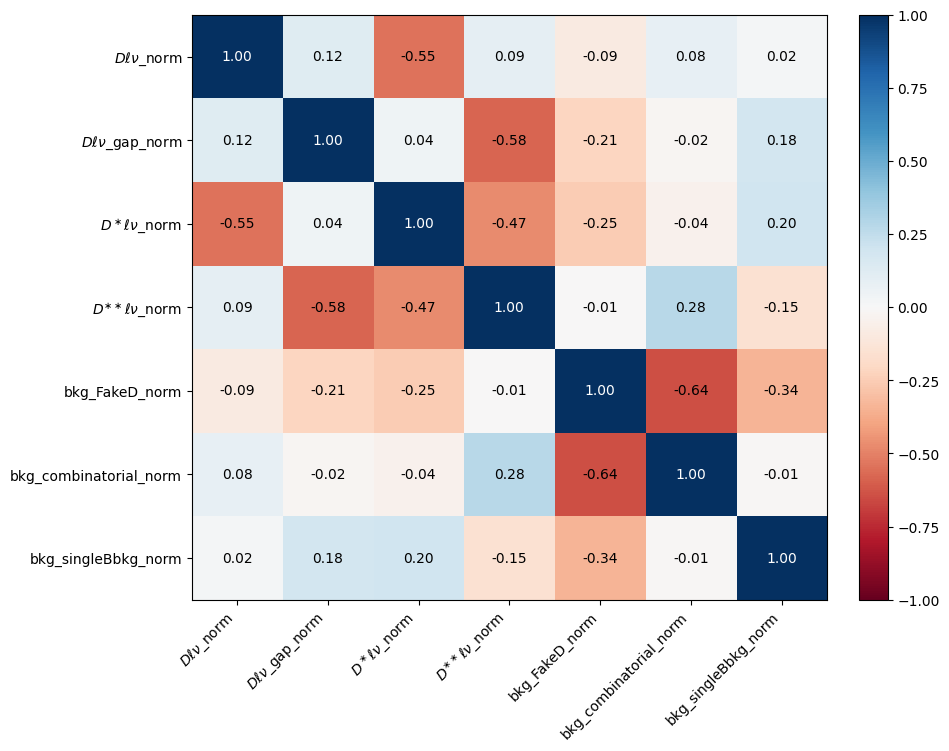

In [15]:
# 3/ab template with weight=0.12 and no staterror
cabinetry.visualize.correlation_matrix(res, pruning_threshold=0.3)

In [96]:
temp_2d, stat_2d,data_2d = util.create_2d_template(
    template_flat=temp_asimov_e[0],
    staterror_flat=temp_asimov_e[1],
    data_flat=toys[0][:1136],
    indices_threshold=indices_threshold_e,
    bins=[MM2_bins, p_D_l_bins])

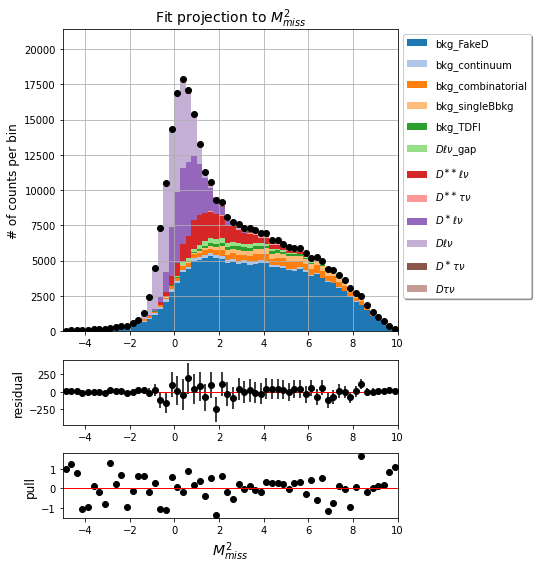

In [97]:
fig = util.fit_project_cabinetry(fit_result=res, templates_2d=temp_2d,
                      staterror_2d=stat_2d,data_2d=data_2d, 
                      edges_list=[MM2_bins, p_D_l_bins], 
                      direction='mm2', slice_thresholds=None)

In [ ]:
fig = util.fit_project_cabinetry(fit_result=res, templates_2d=temp_2d,
                      staterror_2d=stat_2d,data_2d=data_2d, 
                      edges_list=[MM2_bins, p_D_l_bins], 
                      direction='p_D_l', slice_thresholds=None)

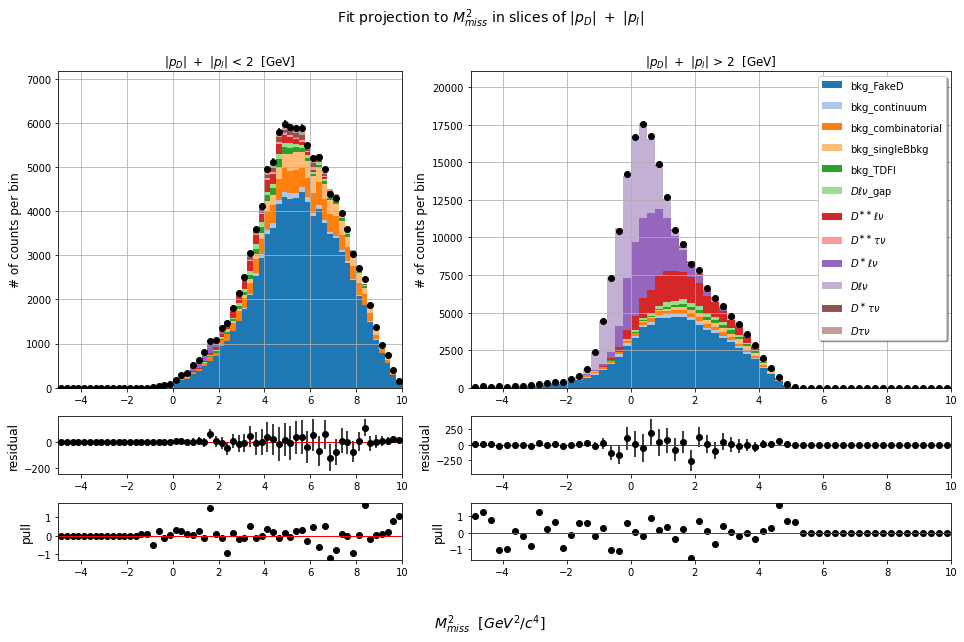

In [99]:
fig = util.fit_project_cabinetry(fit_result=res, templates_2d=temp_2d,
                      staterror_2d=stat_2d,data_2d=data_2d, 
                      edges_list=[MM2_bins, p_D_l_bins], 
                      direction='mm2', slice_thresholds=[2,2])

In [ ]:
fig = util.fit_project_cabinetry(fit_result=res, templates_2d=temp_2d,
                      staterror_2d=stat_2d,data_2d=data_2d, 
                      edges_list=[MM2_bins, p_D_l_bins], 
                      direction='p_D_l', slice_thresholds=[2,2])

DEBUG - cabinetry.model_utils - total stdev is [[1, 2.24, 1.41, 2.24, 1.73, 1.41, 2.65, ..., 5.2, 1, 2, 3.87, 1, 1, 1], ...]
DEBUG - cabinetry.model_utils - total stdev per channel is [300, 300]
INFO - cabinetry.visualize.utils - saving figure as figures/e_channel_prefit.pdf
INFO - cabinetry.visualize.utils - saving figure as figures/mu_channel_prefit.pdf


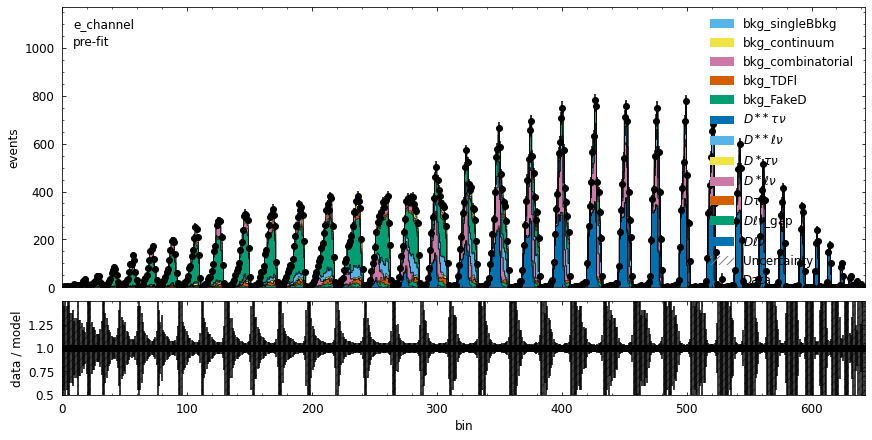

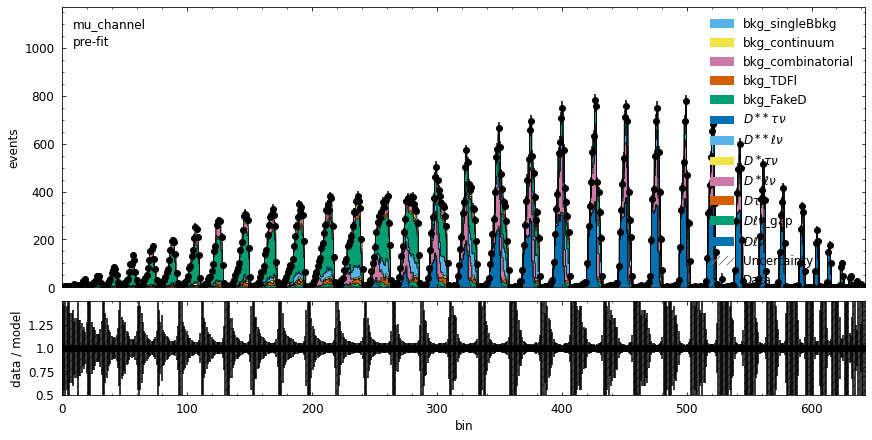

In [21]:
model_pred_prefit = cabinetry.model_utils.prediction(model)
#plt.figure(figsize=(16,6))
dms = cabinetry.visualize.data_mc(model_pred_prefit, data, log_scale=False)
for i in dms:
    i['figure'].set_figwidth(12)